In [198]:
import pandas as pd
import sqlite3 as sql
import numpy as np
import re
import string
import os

# Load in data

In [512]:
## load in epa vehicle data for all years 1985 onwards. Join adjusted weight data to this
epa_df = pd.read_xml("/Users/josheverts/Downloads/vehicles.xml")

## load in data from 2017-2023 stored as excel files
path = "/Users/josheverts/Documents/Epa_AdjWeights/Excel"
os.chdir(path)
## data to join with adjusted weights
weight_dfs = []
for file in os.listdir():
    weight_dfs.append(pd.read_excel(file))

## load in data from 2000-2016, stored as .csv files
path = "/Users/josheverts/Documents/Epa_AdjWeights/csv"
os.chdir(path)
yrs = [] ## record year for data cleaning functions
csv_dfs = []
for file in os.listdir():
    df = pd.DataFrame()
    # Check whether file is in text format or not
    if file.endswith(".csv"):
        yrs.append(int(file[:2]))
        csv_dfs.append(pd.read_csv(file))

In [513]:
## save data into datframes for later use
combined_df1723 = concat_weight_data(weight_dfs, np.arange(17,24)) 
combined_csv0016 = concat_weight_data(csv_dfs, yrs)

# Data cleaning and joining functions
The data differs from year to year and the two datasets don't share a unique vehicle ID. Therefore we have to 
approximate a unique id with the vehicle model column. While this doesn't give a perfect join, it gives reasonable adjusted weight values to work with later. Before 2010 we join on both the make and the model, before 2009 we only join on the model because the models are recorded very differently between the datasets.

In [504]:
def clean_index_adj_weights(adj_weight_df, yr):
    if yr >= 10: ## 2010 or later
        adj_weight_df_grouped = adj_weight_df.groupby(['Represented Test Veh Make',
                                                       'Represented Test Veh Model', 
                                                       'Veh Mfr Code'], group_keys = False).mean(numeric_only = True)
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.rename(columns = {'index':'VehicleID'})
        rename_dict = {'Model Year': 'Year', 'Represented Test Veh Make':'Make', 'Veh Mfr Code': 'MFRCode',
                   'Represented Test Veh Model':'Model', 'Equivalent Test Weight (lbs.)':'AdjWeight'}
        epa_adj_weights = adj_weight_df_grouped.rename(rename_dict, axis=1)  
        epa_adj_weights = epa_adj_weights[['VehicleID', 'Year', 'MFRCode', 'Make', 'Model', 'AdjWeight']]
        epa_adj_weights.astype({'Year': 'int32'})
    else:        
        adj_weight_df_grouped = adj_weight_df.groupby(['VI_MFR_NM',
                                                       'CL_NM', 
                                                       'VI_MFR_CD'], group_keys = False).mean(numeric_only = True)
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.reset_index()
        adj_weight_df_grouped = adj_weight_df_grouped.rename(columns = {'index':'VehicleID'})
        rename_dict = {'MDLYR_DT': 'Year', 'VI_MFR_NM':'Make', 'VI_MFR_CD': 'MFRCode',
                   'CL_NM':'Model', 'VC_DSN_ETW_MSR':'AdjWeight'}
        epa_adj_weights = adj_weight_df_grouped.rename(rename_dict, axis=1)  
        epa_adj_weights = epa_adj_weights[['VehicleID', 'Year', 'MFRCode', 'Make', 'Model', 'AdjWeight']]
        epa_adj_weights.astype({'Year': 'int32'})
        
    return epa_adj_weights

def clean_index_vehicle_data(vehicle_df):
    
    ## rename columns of each df
    rename_dict = {'id': 'VehicleID', 'make': 'Make', 'model':'Model', 'mfrCode':'MFRCode', 'range': 'Range',
              'rangeHwy': 'RangeHwy', 'year':'Year'}
    vehicle_df = vehicle_df.rename(rename_dict, axis=1)
    
    ## vehicle atvType are:
    vehicle_df['atvType'].unique()
    ## if None or Diesel, assign ICE
    ## if Hybrid assign HEV
    ## if Plug-in Hybrid assigh PHEV
    ## if FFV assign FCV
    def convert_vals(vals):
        out = []
        for val in vals:
            if pd.isna(val) == True or val == 'Diesel':
                out.append('ICE')
            elif val == 'Hybrid':
                out.append('HEV')
            elif val == 'Plug-in Hybrid':
                out.append('PHEV')
            elif val == 'EV':
                out.append(val)
            elif val == 'FFV':
                out.append('FCV')
            else:
                out.append(None)
        return out
    new_codes = convert_vals(vehicle_df['atvType'])
    vehicle_df['atvType'] = new_codes
    vehicle_df = vehicle_df[['VehicleID', 'Year', 'MFRCode', 'Make', 'Model', 
                             'Range', 'RangeHwy', 'rangeHwyA','atvType', 
                             'UHighway', 'UCity', 'city08', 'highway08', 'combE', 
                             'combinedUF', 'comb08', 'trany', 'cylinders', 'displ', 'baseModel']]
    return vehicle_df

def concat_weight_data(weight_dfs, yrs):
    combined = pd.DataFrame()
    for df, yr in zip(weight_dfs, yrs):
        cleaned = clean_index_adj_weights(df, yr)
        combined = pd.concat([combined, cleaned])
    combined['Year'] = combined['Year'].astype('int')
    combined['VehicleID'] = np.arange(0, len(combined)) ## assign new unique ids
    combined = combined.reset_index().drop(['index'], axis = 1)
    return combined
        
    
def vehicle_data_join(vehicle_df, combined_weights):
    vehicle_df = vehicle_df.copy(); combined_weights = combined_weights.copy()
    tempdf = vehicle_df[['VehicleID','Year','Make', 'Model']]
    tempdf2 = vehicle_df[['VehicleID', 'Make', 'Model', 'trany', 'displ', 'cylinders', 'atvType']]
    vehicle_df['Make'] = vehicle_df['Make'].str.lower()
    vehicle_df['baseModel'] = vehicle_df['baseModel'].str.lower()
    vehicle_df['Model'] = vehicle_df['Model'].str.lower()
    combined_weights['Make'] = combined_weights['Make'].str.lower()
    combined_weights['Model'] = combined_weights['Model'].str.lower()
    combined_weights['baseModel'] = [i.split(' ')[0] for i in combined_weights['Model']]
    ## have to treat pre-2009 years differently, merge on Year, baseModel, not Make
    data_before_09 = combined_weights[combined_weights['Year'] < 2010]
    data_after_09 = combined_weights[combined_weights['Year'] >= 2010]
    adj_join_before_09 = pd.merge(vehicle_df, combined_weights, how='inner', 
                        left_on=['Year','baseModel'], right_on = ['Year','baseModel'])
    adj_join_after_09 = pd.merge(vehicle_df, combined_weights, how='inner', 
                        left_on=['Year', 'Make','baseModel'], right_on = ['Year', 'Make','baseModel'])
    ## combine initial joins
    adj_join = pd.concat([adj_join_before_09, adj_join_after_09])
    adj_join_g = adj_join.groupby(['VehicleID_x']).agg({'UHighway': np.mean, 'UCity': np.mean, 'city08': np.mean, 
                                                    'Range': np.mean, 'RangeHwy': np.mean, 'rangeHwyA': np.mean,
                                                    'highway08':  np.mean, 'combE': np.mean, 'combinedUF': np.mean, 
                                                    'comb08': np.mean, 'AdjWeight': np.mean})  
    adj_join_g_j = pd.merge(adj_join_g, tempdf2, how = 'inner', left_on='VehicleID_x', right_on='VehicleID')
    adj_join_final_cap = pd.merge(adj_join_g_j, tempdf, how = 'inner', left_on='VehicleID', right_on='VehicleID')
    adj_join_final_cap_drop = adj_join_final_cap.drop(['Make_x', 'Model_x'], axis = 1)
    adj_join_final_cap_drop = adj_join_final_cap_drop.rename({'Make_y': 'Make', 'Model_y': 'Model'}, axis = 1)
    adj_join_final_cap_drop = adj_join_final_cap_drop[~adj_join_final_cap_drop.duplicated(['Year', 'Make', 'Model', 'trany', 'displ', 'cylinders'])]
    cols = adj_join_final_cap_drop.columns.to_list()
    cols = cols[::-1]
    adj_join_final_cap_drop = adj_join_final_cap_drop[cols]
    adj_join_final_cap_drop = adj_join_final_cap_drop.reset_index().drop(['index'], axis = 1)
    
    return adj_join_final_cap_drop


# Join epa vehicle data to adjusted weight data

In [516]:
### First join the 2000-2016 data, then join the 2017-2023 data
epa_df_cleaned = clean_index_vehicle_data(epa_df)
joined_data_00_16 = vehicle_data_join(epa_df_cleaned, combined_csv0016)
joined_data_17_23 = vehicle_data_join(epa_df_cleaned, combined_df1723)
## combine joined dataframes to create years 2000-2023
joined_data_00_23 = pd.concat([joined_data_00_16, joined_data_17_23])
joined_data_00_23['VehicleID'] = np.arange(0, len(joined_data_00_23)) ## assign new unique ids
joined_data_00_23 = joined_data_00_23.reset_index().drop(['index'], axis = 1)

Text(0.5, 1.0, 'Adjusted Weight Distribution for Vehicles 2000-2023')

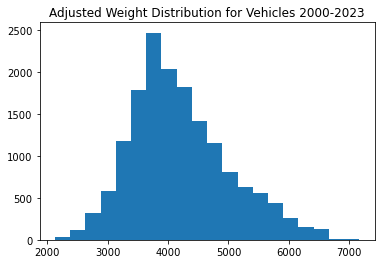

In [517]:
plt.hist(joined_data_00_23['AdjWeight'], bins = 20)
plt.title("Adjusted Weight Distribution for Vehicles 2000-2023")

Text(0.5, 1.0, 'Number of vehicle models per year in joined data')

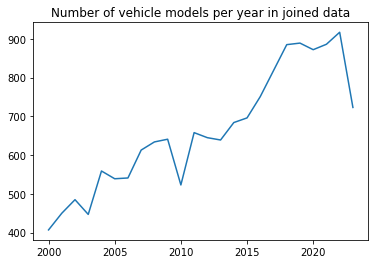

In [518]:
plt.plot(joined_data_00_23.groupby('Year').count()['Model'])
plt.title("Number of vehicle models per year in joined data")

In [425]:
joined_data_00_23.to_csv("adj_weight_data_join_2000-2023.csv", index = False)